In [1]:
import re
import numpy as np
import string
import pprint
from bs4 import UnicodeDammit

from nltk.corpus import PlaintextCorpusReader
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import PorterStemmer, SnowballStemmer

# import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from helpers import plot_confusion_matrix, weird_stuff
from profiles import profile_list

%matplotlib inline

with open('hygiene.dat.labels.txt', 'r') as f:
    lables = f.readlines()
    lables = [int(l.replace('\n', '')) for l in lables if '[None]' not in l]
    lables = np.array(lables)

In [7]:
punt_map = dict(zip(string.punctuation, ['' for _ in  range(len(string.punctuation))]))
punt_map['.'] = ' '
punt_map['?'] = ' '
punt_map['!'] = ' '
translator = str.maketrans(punt_map)

wnl = WordNetLemmatizer()
pts = PorterStemmer()
sbs = SnowballStemmer('english')

def tokenize(text):
    tokens = word_tokenize(text)
    stems = [wnl.lemmatize(t) for t in tokens]
    return stems

In [8]:
with open('Hygiene/hygiene.dat', 'r') as f:
    lines = f.readlines()

token_dict = dict()
for idx, line in enumerate(lines):    
    line = line.lower()
    for weird_character in weird_stuff:
        line = line.replace(weird_character, weird_stuff[weird_character]['replace'])
    line = line.translate(translator)
    line = re.sub('\s+', ' ', line).strip()
    line = UnicodeDammit(line).unicode_markup
    token_dict[idx] = line

In [12]:
from scipy.sparse import csr_matrix

def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [10]:
tfidf = TfidfVectorizer(
    tokenizer=tokenize, 
    stop_words='english',
    input='content', 
    encoding='utf-8', 
    decode_error='strict', 
    strip_accents=None, 
    lowercase=True, 
    preprocessor=None,
    ngram_range=(1, 1), 
    max_df=0.8, 
    min_df=2,  
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False
)
tfs = tfidf.fit_transform(token_dict.values())
save_sparse_csr('unigram_tfidf_0.8_2', tfs)

tfidf = TfidfVectorizer(
    tokenizer=tokenize, 
    stop_words='english',
    input='content', 
    encoding='utf-8', 
    decode_error='strict', 
    strip_accents=None, 
    lowercase=True, 
    preprocessor=None,
    ngram_range=(2, 2), 
    max_df=0.8, 
    min_df=2,  
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False
)
tfs = tfidf.fit_transform(token_dict.values())
save_sparse_csr('bigram_tfidf_0.8_2', tfs)

tfidf = TfidfVectorizer(
    tokenizer=tokenize, 
    stop_words='english',
    input='content', 
    encoding='utf-8', 
    decode_error='strict', 
    strip_accents=None, 
    lowercase=True, 
    preprocessor=None,
    ngram_range=(1, 2), 
    max_df=0.8, 
    min_df=2,  
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False
)
tfs = tfidf.fit_transform(token_dict.values())
save_sparse_csr('mixgram_tfidf_0.8_2', tfs)

# SGDClassifier

/Users/tbrooks/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training Data
F1 score: 0.9505005288142264
Test Data
F1 score: 0.8771394744094458
Confusion matrix, without normalization
[[2846  113]
 [ 163 2478]]
Confusion matrix, without normalization
[[668  68]
 [103 561]]


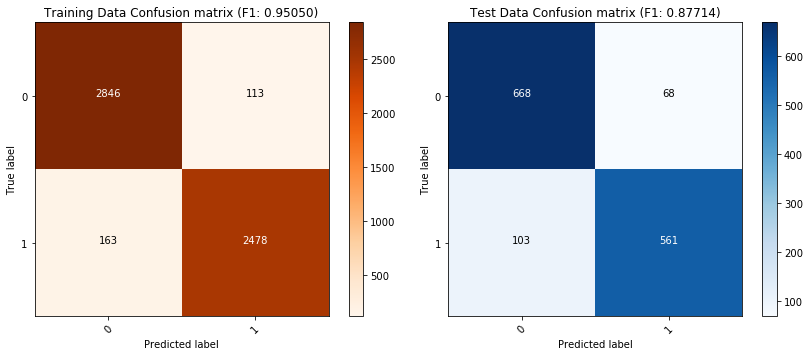

In [16]:
tfs = load_sparse_csr('unigram_tfidf_0.8_2.npz')
x_train, x_test, y_train, y_test = train_test_split(tfs[:len(lables)], lables, test_size=0.2)

clf = linear_model.stochastic_gradient.SGDClassifier(
    loss='hinge',  
    penalty='l2', 
    alpha=0.00018, # default 0.0001
    n_jobs=3, # default 1
)
clf.fit(x_train, y_train)
np.set_printoptions(precision=2)
print('Training Data')
y_pred_train = clf.predict(x_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('F1 score: {}'.format(f1_train))
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

print('Test Data')
y_pred1 = clf.predict(x_test)
f1 = f1_score(y_test, y_pred1, average='macro')
print('F1 score: {}'.format(f1))
cnf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cnf_matrix_train, 
    [0,1],
    normalize=False,
    title='Training Data Confusion matrix (F1: {:.5f})'.format(f1_train),
    cmap=plt.cm.Oranges
)

plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cnf_matrix, 
    [0,1],
    normalize=False,
    title='Test Data Confusion matrix (F1: {:.5f})'.format(f1),
    cmap=plt.cm.Blues
)

/Users/tbrooks/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training Data
F1 score: 0.9946292377392212
Test Data
F1 score: 0.81298354603683
Confusion matrix, without normalization
[[2926   17]
 [  13 2644]]
Confusion matrix, without normalization
[[702  50]
 [203 445]]


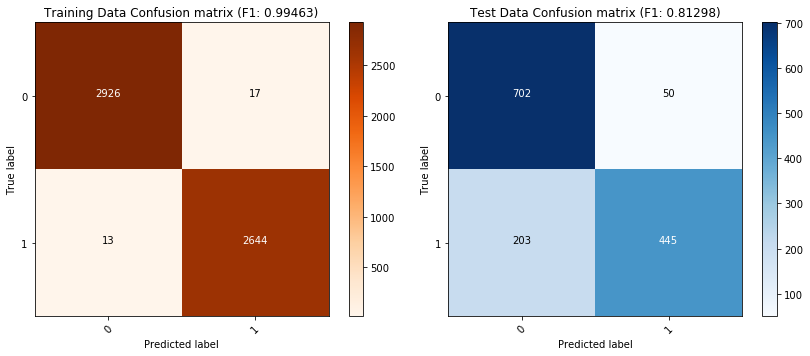

In [17]:
tfs = load_sparse_csr('bigram_tfidf_0.8_2.npz')
x_train, x_test, y_train, y_test = train_test_split(tfs[:len(lables)], lables, test_size=0.2)

clf = linear_model.stochastic_gradient.SGDClassifier(
    loss='hinge',  
    penalty='l2', 
    alpha=0.00018, # default 0.0001
    n_jobs=3, # default 1
)
clf.fit(x_train, y_train)
np.set_printoptions(precision=2)
print('Training Data')
y_pred_train = clf.predict(x_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('F1 score: {}'.format(f1_train))
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

print('Test Data')
y_pred1 = clf.predict(x_test)
f1 = f1_score(y_test, y_pred1, average='macro')
print('F1 score: {}'.format(f1))
cnf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cnf_matrix_train, 
    [0,1],
    normalize=False,
    title='Training Data Confusion matrix (F1: {:.5f})'.format(f1_train),
    cmap=plt.cm.Oranges
)

plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cnf_matrix, 
    [0,1],
    normalize=False,
    title='Test Data Confusion matrix (F1: {:.5f})'.format(f1),
    cmap=plt.cm.Blues
)

/Users/tbrooks/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training Data
F1 score: 0.979932826159404
Test Data
F1 score: 0.8524058467129294
Confusion matrix, without normalization
[[2906   52]
 [  60 2582]]
Confusion matrix, without normalization
[[677  60]
 [144 519]]


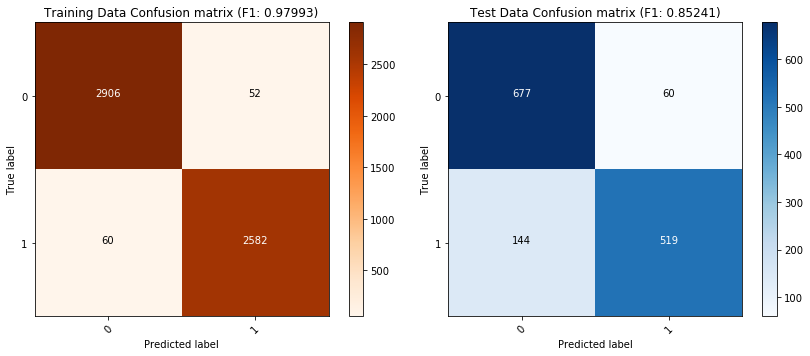

In [18]:
tfs = load_sparse_csr('mixgram_tfidf_0.8_2.npz')
x_train, x_test, y_train, y_test = train_test_split(tfs[:len(lables)], lables, test_size=0.2)

clf = linear_model.stochastic_gradient.SGDClassifier(
    loss='hinge',  
    penalty='l2', 
    alpha=0.00018, # default 0.0001
    n_jobs=3, # default 1
)
clf.fit(x_train, y_train)
np.set_printoptions(precision=2)
print('Training Data')
y_pred_train = clf.predict(x_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('F1 score: {}'.format(f1_train))
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

print('Test Data')
y_pred1 = clf.predict(x_test)
f1 = f1_score(y_test, y_pred1, average='macro')
print('F1 score: {}'.format(f1))
cnf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cnf_matrix_train, 
    [0,1],
    normalize=False,
    title='Training Data Confusion matrix (F1: {:.5f})'.format(f1_train),
    cmap=plt.cm.Oranges
)

plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cnf_matrix, 
    [0,1],
    normalize=False,
    title='Test Data Confusion matrix (F1: {:.5f})'.format(f1),
    cmap=plt.cm.Blues
)

# GradientBoostingClassifier

Score 0.7935714285714286
Training Data
F1 score: 0.8579562988720398
Test Data
F1 score: 0.7908048223469673
Confusion matrix, without normalization
[[2695  259]
 [ 528 2118]]
Confusion matrix, without normalization
[[636 105]
 [184 475]]


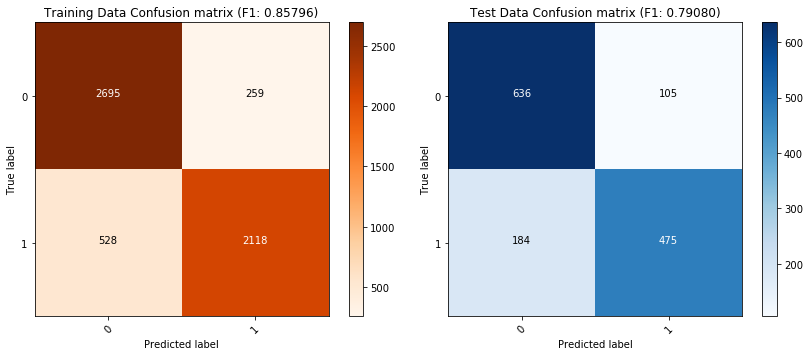

In [20]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

tfs = load_sparse_csr('unigram_tfidf_0.8_2.npz')
x_train, x_test, y_train, y_test = train_test_split(tfs[:len(lables)], lables, test_size=0.2)

clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(x_train, y_train)
score = clf.score(x_test, y_test)
print('Score {}'.format(score))

print('Training Data')
y_pred_train = clf.predict(x_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('F1 score: {}'.format(f1_train))
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

print('Test Data')
y_pred1 = clf.predict(x_test)
f1 = f1_score(y_test, y_pred1, average='macro')
print('F1 score: {}'.format(f1))
cnf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cnf_matrix_train, 
    [0,1],
    normalize=False,
    title='Training Data Confusion matrix (F1: {:.5f})'.format(f1_train),
    cmap=plt.cm.Oranges
)

plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cnf_matrix, 
    [0,1],
    normalize=False,
    title='Test Data Confusion matrix (F1: {:.5f})'.format(f1),
    cmap=plt.cm.Blues
)

Score 0.7278571428571429
Training Data
F1 score: 0.8027289166529673
Test Data
F1 score: 0.7179018114257698
Confusion matrix, without normalization
[[2860  134]
 [ 922 1684]]
Confusion matrix, without normalization
[[641  60]
 [321 378]]


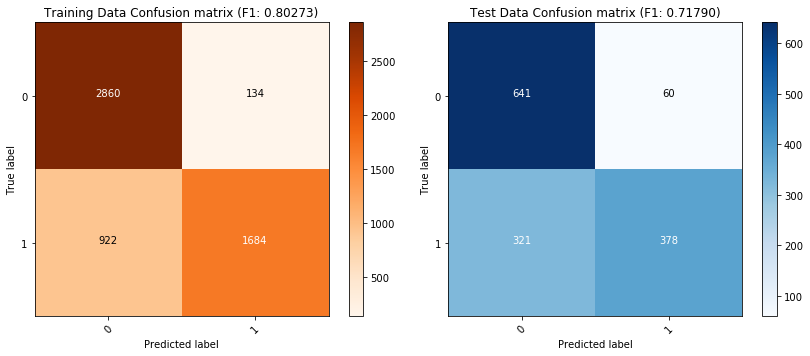

In [21]:
tfs = load_sparse_csr('bigram_tfidf_0.8_2.npz')
x_train, x_test, y_train, y_test = train_test_split(tfs[:len(lables)], lables, test_size=0.2)

clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(x_train, y_train)
score = clf.score(x_test, y_test)
print('Score {}'.format(score))

print('Training Data')
y_pred_train = clf.predict(x_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('F1 score: {}'.format(f1_train))
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

print('Test Data')
y_pred1 = clf.predict(x_test)
f1 = f1_score(y_test, y_pred1, average='macro')
print('F1 score: {}'.format(f1))
cnf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cnf_matrix_train, 
    [0,1],
    normalize=False,
    title='Training Data Confusion matrix (F1: {:.5f})'.format(f1_train),
    cmap=plt.cm.Oranges
)

plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cnf_matrix, 
    [0,1],
    normalize=False,
    title='Test Data Confusion matrix (F1: {:.5f})'.format(f1),
    cmap=plt.cm.Blues
)

Score 0.7985714285714286
Training Data
F1 score: 0.8560233504699655
Test Data
F1 score: 0.7960389819720778
Confusion matrix, without normalization
[[2718  250]
 [ 546 2086]]
Confusion matrix, without normalization
[[637  90]
 [192 481]]


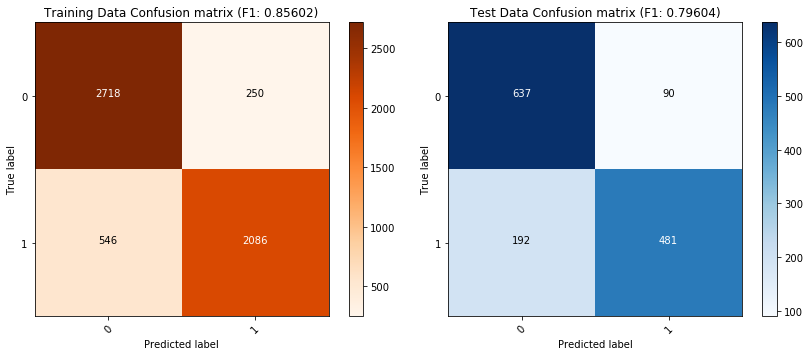

In [22]:
tfs = load_sparse_csr('mixgram_tfidf_0.8_2.npz')
x_train, x_test, y_train, y_test = train_test_split(tfs[:len(lables)], lables, test_size=0.2)

clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(x_train, y_train)
score = clf.score(x_test, y_test)
print('Score {}'.format(score))

print('Training Data')
y_pred_train = clf.predict(x_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('F1 score: {}'.format(f1_train))
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

print('Test Data')
y_pred1 = clf.predict(x_test)
f1 = f1_score(y_test, y_pred1, average='macro')
print('F1 score: {}'.format(f1))
cnf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cnf_matrix_train, 
    [0,1],
    normalize=False,
    title='Training Data Confusion matrix (F1: {:.5f})'.format(f1_train),
    cmap=plt.cm.Oranges
)

plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cnf_matrix, 
    [0,1],
    normalize=False,
    title='Test Data Confusion matrix (F1: {:.5f})'.format(f1),
    cmap=plt.cm.Blues
)